### Цели и описание проекта

Тестовое задание Data Science:

Задача: создать модель МО, которая будет определять направление цены.

Срок: до 1 недели

Метрика: решаете сами

Как сдавать: ссылку на google colab с выводами.

Особенности: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.


Описание:
date - дата

open - цена открытия

high - цена максимум

low - цена минимум

close - цена закрытия

vol  - объем

target - целевая переменная (направление движения цены на следующий день 0 - вниз 1 - вверх).


### Загрузка и предобработка

In [422]:
!pip install ta -q

In [423]:
import holidays
import numpy as np
import pandas as pd

import gdown
import matplotlib.pyplot as plt
import ta
from google.colab import files

from lightgbm import LGBMClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    mean_squared_error,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

RANDOM_STATE = 42
TEST_SIZE = 0.2


In [424]:
file_id = '1qtsnuL4AftbX8A3EvA6FcZhV9mrS_hgV'
download_url = f'https://drive.google.com/uc?id={file_id}'
output = 'data.csv'
gdown.download(download_url, output, quiet=False)
df = pd.read_csv(
    output,
    sep=';',
    decimal=',',
)

df.head()

Downloading...
From: https://drive.google.com/uc?id=1qtsnuL4AftbX8A3EvA6FcZhV9mrS_hgV
To: /content/data.csv
100%|██████████| 106k/106k [00:00<00:00, 62.3MB/s]


,date,open,high,low,close,vol,target
0,20140616,2092.2,2153.3,2067.3,2149.0,3720757,0
1,20140617,2205.1,2205.1,2122.5,2130.0,1494451,0
2,20140618,2135.0,2152.3,2121.8,2126.9,1129635,0
3,20140619,2140.0,2147.9,2112.0,2112.1,1140105,0
4,20140620,2119.0,2127.3,2086.1,2100.0,1067446,0


In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2507 non-null   int64  
 1   open    2507 non-null   float64
 2   high    2507 non-null   float64
 3   low     2507 non-null   float64
 4   close   2507 non-null   float64
 5   vol     2507 non-null   int64  
 6   target  2507 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 137.2 KB


In [426]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,vol,target
date,,,,,,
2014-06-16,2092.2,2153.3,2067.3,2149.0,3720757,0
2014-06-17,2205.1,2205.1,2122.5,2130.0,1494451,0
2014-06-18,2135.0,2152.3,2121.8,2126.9,1129635,0
2014-06-19,2140.0,2147.9,2112.0,2112.1,1140105,0
2014-06-20,2119.0,2127.3,2086.1,2100.0,1067446,0


In [427]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 2014-06-16 to 2024-06-14
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2507 non-null   float64
 1   high    2507 non-null   float64
 2   low     2507 non-null   float64
 3   close   2507 non-null   float64
 4   vol     2507 non-null   int64  
 5   target  2507 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 137.1 KB


Преобразований типов не требуется

In [428]:
df.describe()

,open,high,low,close,vol,target
count,2507.000000,2507.000000,2507.000000,2507.000000,2.507000e+03,2507.000000
mean,4460.243638,4511.057519,4405.094655,4461.615836,9.725856e+05,0.512964
std,1601.778261,1614.741585,1585.718511,1601.606745,6.599666e+05,0.499932
min,1916.000000,1949.000000,1911.500000,1925.100000,5.404300e+04,0.000000
25%,2939.050000,2964.750000,2901.750000,2936.500000,5.602675e+05,0.000000
50%,4452.000000,4512.500000,4381.500000,4456.000000,8.043300e+05,1.000000
75%,5621.500000,5692.500000,5566.500000,5618.750000,1.197488e+06,1.000000
max,8152.500000,8175.000000,8080.000000,8152.000000,7.526760e+06,1.000000


Диапазон значений признаков находится в допустимых пределах

In [429]:
df[df.duplicated()]

,open,high,low,close,vol,target
date,,,,,,


Дублирующие строки не обнаружены

In [430]:
df.isna().sum()

,0
open,0
high,0
low,0
close,0
vol,0
target,0


Пропусков нет

#### Выводы по разделу Загрузка и предобработка данных
- Данные загружены из csv файла, который был скачан с гугл диска
- Изменение типов данных не требуется
- Даты преобразованы в формат dateframe и установлены индексом данных
- В данных отсутствуют пропуски и дубликаты

### Исследовательский анализ данных

Только с представленными данными не получилось получить приемлимую метрику для акции Лукойла, принял решение дополнить датасет следующими данными: индекс Голубые фишки, индекс Нефти и газа и Brent. данные взяты из сайта: https://www.finam.ru/profile/moex-akcii/surgut/export/old/

In [431]:
file_id = "1MWrT2eEvRIqqtFdImyES9neDQs3oFkIQ"
download_url = f"https://drive.google.com/uc?id={file_id}"

output_path = "features.csv"
gdown.download(download_url, output_path, quiet=False)

features_data = pd.read_csv(output_path, sep=';')

features_data['date'] = pd.to_datetime(features_data['date'])
features_data.set_index('date', inplace=True)

df = df.merge(features_data.shift(), on='date', how='left')

In [432]:
df['target'].value_counts()

,count
target,
1,1286
0,1228


Данные хорошо сбалансированы, следовательно балансировки класса не требуется. Принял решение оценивать модель по метрике accuracy

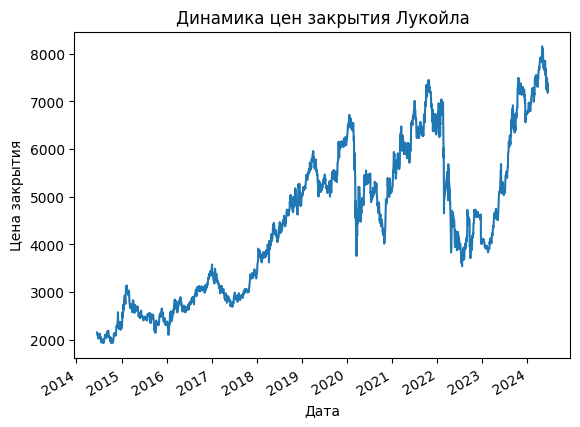

In [433]:
df['close'].plot()
plt.title('Динамика цен закрытия Лукойла')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

Видны резкие скачки в 2020 году (ковид) и в 2022 году(СВО). Проверим что ряд стационарный.

In [434]:
# Функция для выполнения ADF-теста
def ADF_test(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    if result[1] < 0.05:
        print("Ряд стационарный (отвергаем нулевую гипотезу).")
    else:
        print("Ряд НЕ стационарный (не отвергаем нулевую гипотезу).")

print("ADF тест закрытия Лукойла\n")
ADF_test(df['close'])

print("\nADF тест открытия Лукойла\n")
ADF_test(df['open'])

print("\nADF тест максимума Лукойла\n")
ADF_test(df['high'])

print("\nADF тест минимума Лукойла\n")
ADF_test(df['low'])

print("\nADF тест объема Лукойла\n")
ADF_test(df['vol'])

ADF тест закрытия Лукойла

ADF Statistic: -1.387909280937294
p-value: 0.5880586394812688
Critical Values: {'1%': np.float64(-3.4329821119179256), '5%': np.float64(-2.862702850392563), '10%': np.float64(-2.5673890307492004)}
Ряд НЕ стационарный (не отвергаем нулевую гипотезу).

ADF тест открытия Лукойла

ADF Statistic: -1.4259245349772325
p-value: 0.569786417479288
Critical Values: {'1%': np.float64(-3.4329810529006184), '5%': np.float64(-2.862702382731847), '10%': np.float64(-2.5673887817601657)}
Ряд НЕ стационарный (не отвергаем нулевую гипотезу).

ADF тест максимума Лукойла

ADF Statistic: -1.3537130707013378
p-value: 0.604254693846115
Critical Values: {'1%': np.float64(-3.4329789374204935), '5%': np.float64(-2.8627014485379787), '10%': np.float64(-2.5673882843825098)}
Ряд НЕ стационарный (не отвергаем нулевую гипотезу).

ADF тест минимума Лукойла

ADF Statistic: -1.4922538074942613
p-value: 0.5373397300479613
Critical Values: {'1%': np.float64(-3.4329810529006184), '5%': np.float64(

Наблюдается тренды необходимо дифференцировать цены, объем оставляем как есть

In [435]:
# Диффиренцирование
df['close_diff'] = df['close'].diff().shift()
df['open_diff'] = df['open'].diff().shift()
df['high_diff'] = df['high'].diff().shift()
df['low_diff'] = df['low'].diff().shift()

In [436]:
print("ADF тест закрытия Лукойла\n")
ADF_test(df['close_diff'].dropna())

print("\nADF тест открытия Лукойла\n")
ADF_test(df['open_diff'].dropna())

print("\nADF тест максимума Лукойла\n")
ADF_test(df['high_diff'].dropna())

print("\nADF тест минимума Лукойла\n")
ADF_test(df['low_diff'].dropna())

ADF тест закрытия Лукойла

ADF Statistic: -8.851084565306984
p-value: 1.5722962151677642e-14
Critical Values: {'1%': np.float64(-3.432985294091178), '5%': np.float64(-2.862704255635287), '10%': np.float64(-2.567389778920032)}
Ряд стационарный (отвергаем нулевую гипотезу).

ADF тест открытия Лукойла

ADF Statistic: -8.732646113343547
p-value: 3.161092791348004e-14
Critical Values: {'1%': np.float64(-3.432985294091178), '5%': np.float64(-2.862704255635287), '10%': np.float64(-2.567389778920032)}
Ряд стационарный (отвергаем нулевую гипотезу).

ADF тест максимума Лукойла

ADF Statistic: -9.334481119508451
p-value: 9.14078395297581e-16
Critical Values: {'1%': np.float64(-3.4329799947351503), '5%': np.float64(-2.862701915447137), '10%': np.float64(-2.5673885329713495)}
Ряд стационарный (отвергаем нулевую гипотезу).

ADF тест минимума Лукойла

ADF Statistic: -8.856060774631676
p-value: 1.526836098238403e-14
Critical Values: {'1%': np.float64(-3.4329821119179256), '5%': np.float64(-2.862702850

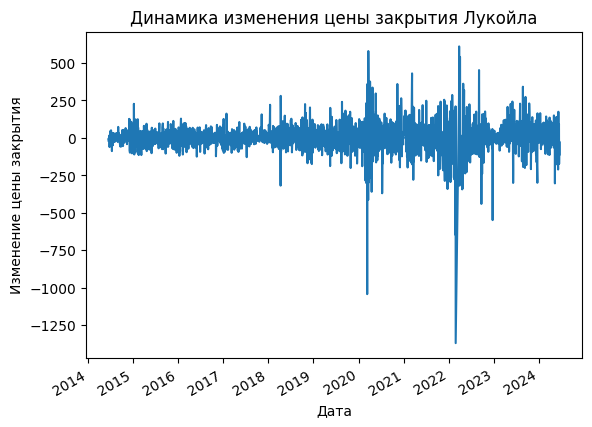

In [437]:
# Динамика изменения цены закрытия Лукойла
df['close_diff'].plot()
plt.title('Динамика изменения цены закрытия Лукойла')
plt.xlabel('Дата')
plt.ylabel('Изменение цены закрытия')
plt.show()

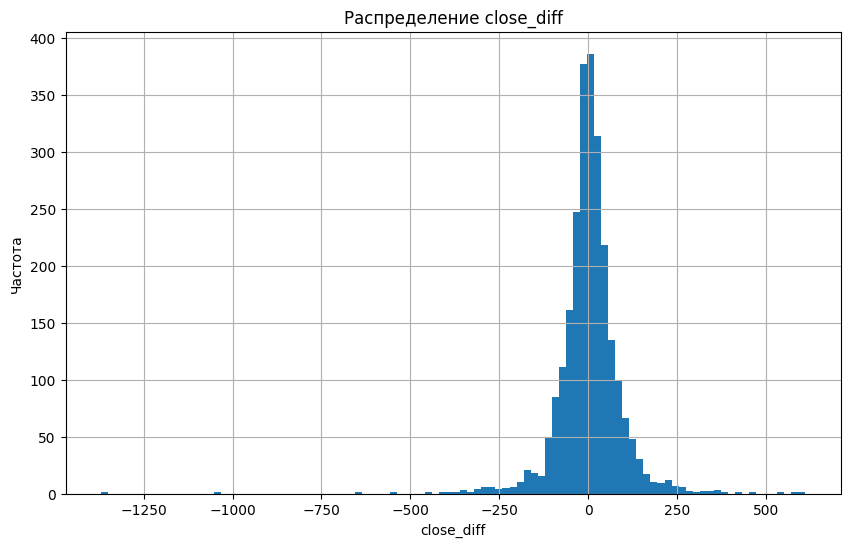

In [438]:
plt.figure(figsize=(10, 6))
df['close_diff'].hist(bins=100)
plt.title('Распределение close_diff')
plt.xlabel('close_diff')
plt.ylabel('Частота')
# plt.grid(True)
plt.show()

изменение цены закрытия Лукойла имеет нормальное распределение, заметны выбросы, связанные с СВО (2022) и ковидом(2020), оставляем все как есть

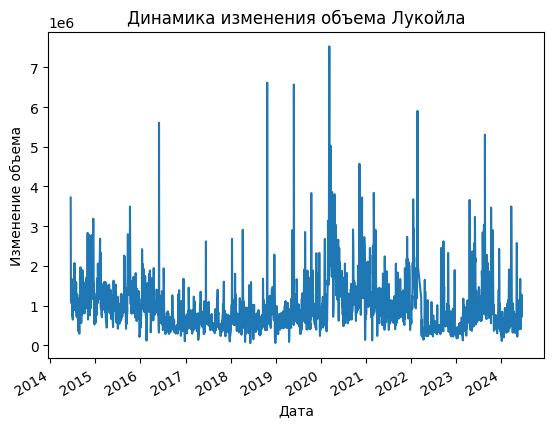

In [439]:
df['vol'].plot()
plt.title('Динамика изменения объема Лукойла')
plt.xlabel('Дата')
plt.ylabel('Изменение объема')
plt.show()

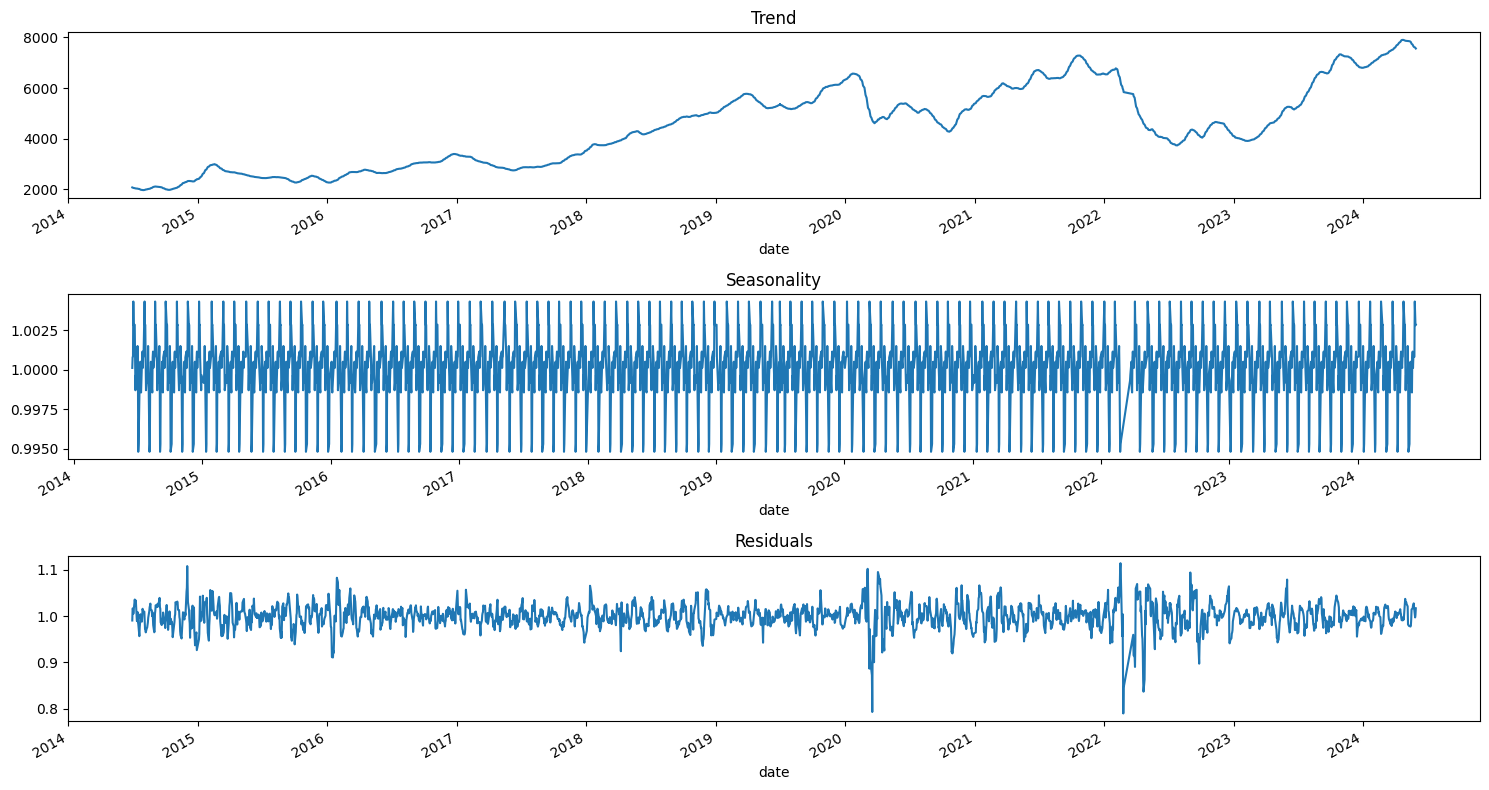

In [440]:
# Декомпозиция временного ряда цен закрытия Лукойла
decomposed = seasonal_decompose(df['close'].dropna(), model='multiplicative', period=22)
plt.figure(figsize=(15, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

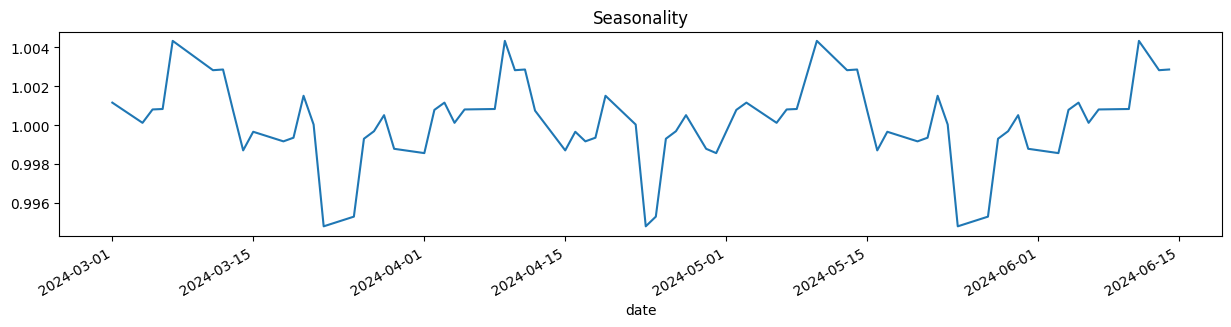

Период сезонности: None


In [441]:
decomposed.seasonal['2024-03-01':].plot(figsize=(15,3))
plt.title('Seasonality')
plt.show()
print("Период сезонности:", decomposed.seasonal.index.freq)

#### Выводы по разделу
- Баланс целевой переменной и выбросы: количество дней с ростом и падением цены примерно одинаково, без сильного перекоса; единичные выбросы по объему и цене логично укладываются в рыночные «волны» (несколько пиковых дней).

- Сезонность (~45 дней): декомпозиция ряда разностей цен (close_diff) выявила циклический компонент около 45 торговых дней, что следует учитывать при выборе окон для rolling‑признаков и параметра period.

- Слабая корреляция объема с ценой: дни с высокими объемами чаще совпадают с крупными движениями цены, но общая корреляция остается невысокой.

- Автокорреляция разностей: close_diff демонстрирует автокорреляцию на лагах 1–2, что говорит о некоторой «памяти» рынка (рост/падение в один день частично повторяются на следующий).

### Создание признаков

In [442]:
def make_features(data):
    # Признаки связанные с временем
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['week_of_year'] = data.index.isocalendar().week.astype(int)
    data['decade_of_month'] = (data['day'] - 1) // 10
    data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)
    data['quarter'] = data.index.quarter
    data['is_month_end'] = data.index.is_month_end.astype(int)
    data['is_month_start'] = data.index.is_month_start.astype(int)
    data['is_quarter_end'] = data.index.is_quarter_end.astype(int)
    data['is_quarter_start'] = data.index.is_quarter_start.astype(int)



    # Признаки индикаторы
    for window in [7, 14, 21, 30, 45]:
        ema = ta.trend.EMAIndicator(close=data['close'], window=window)
        data[f'ema_{window}'] = ema.ema_indicator().shift()

        ema = ta.trend.EMAIndicator(close=data['close_bz'], window=window)
        data[f'ema_bz_{window}'] = ema.ema_indicator()

        ema = ta.trend.EMAIndicator(close=data['close_MOEXBC'], window=window)
        data[f'ema_bc_{window}'] = ema.ema_indicator()

        ema = ta.trend.EMAIndicator(close=data['close_MOEXOG'], window=window)
        data[f'ema_og_{window}'] = ema.ema_indicator()

        rsi = ta.momentum.RSIIndicator(close=data['close'], window=window)
        data[f'rsi_{window}'] = rsi.rsi().shift()

        macd = ta.trend.MACD(close=data['close'])
        data['macd'] = macd.macd().shift()
        data['macd_signal'] = macd.macd_signal().shift()

        adx = ta.trend.ADXIndicator(high=data['high'], low=data['low'], close=data['close'], window=window)
        data[f'adx_{window}'] = adx.adx().shift()

        stoch = ta.momentum.StochasticOscillator(high=data['high'], low=data['low'], close=data['close'], window=window)
        data[f'stoch_k_{window}'] = stoch.stoch().shift()
        data[f'stoch_d_{window}'] = stoch.stoch_signal().shift()

        cci = ta.trend.CCIIndicator(high=data['high'], low=data['low'], close=data['close'], window=window)
        data[f'cci_{window}'] = cci.cci().shift()

        bb = ta.volatility.BollingerBands(close=data['close'], window=window)
        data[f'bb_hband_{window}'] = bb.bollinger_hband().shift()
        data[f'bb_lband_{window}'] = bb.bollinger_lband().shift()
        data[f'bb_mavg_{window}'] = bb.bollinger_mavg().shift()
        data[f'bb_hband_indicator_{window}'] = bb.bollinger_hband_indicator().shift()
        data[f'bb_lband_indicator_{window}'] = bb.bollinger_lband_indicator().shift()

        atr = ta.volatility.AverageTrueRange(high=data['high'], low=data['low'], close=data['close'], window=window)
        data[f'atr_{window}'] = atr.average_true_range().shift()

        roc = ta.momentum.ROCIndicator(close=data['close'], window=window)
        data[f'roc_{window}'] = roc.roc().shift()


    psar = ta.trend.PSARIndicator(high=data['high'], low=data['low'], close=data['close'])
    data['psar'] = psar.psar().shift()

    ichimoku = ta.trend.IchimokuIndicator(high=data['high'], low=data['low'])
    data['ichimoku_a'] = ichimoku.ichimoku_a().shift()
    data['ichimoku_b'] = ichimoku.ichimoku_b().shift()

    obv = ta.volume.OnBalanceVolumeIndicator(close=data['close'], volume=data['vol'])
    data['obv'] = obv.on_balance_volume().shift()

    vwap = ta.volume.VolumeWeightedAveragePrice(high=data['high'], low=data['low'], close=data['close'], volume=data['vol'])
    data['vwap'] = vwap.volume_weighted_average_price().shift()

    cmf = ta.volume.ChaikinMoneyFlowIndicator(high=data['high'], low=data['low'], close=data['close'], volume=data['vol'], window=20)
    data['cmf_20'] = cmf.chaikin_money_flow().shift()



    data['volatility'] = data['high'] - data['low']
    data['volatility_up'] = (data['volatility'] > data['volatility'].shift()).astype(int)
    data['volume_up'] = (data['vol'] > data['vol'].shift()).astype(int)

    # Признаки лаги
    for lag in [1, 3, 5, 7, 10, 14, 21, 30, 45]:
        data[f'lag_close_diff_{lag}'] = data['close_diff'].shift(lag)
        data[f'lag_open_diff_{lag}'] = data['open_diff'].shift(lag)
        data[f'lag_volume_{lag}'] = data['vol'].shift(lag)
        data[f'lag_volatility_{lag}'] = data['volatility'].shift(lag)
        data[f'lag_target_up_{lag}'] = data['target'].shift(lag)
        data[f'lag_vol_up_{lag}'] = data['volume_up'].shift(lag)
        data[f'lag_volatility_up_{lag}'] = data['volatility_up'].shift(lag)

    # Признаки скользящие средние, медианы и накопления
    for window in [ 3, 5, 7, 10, 14, 21, 30, 45]:
        data[f'rolling_mean_close_diff_{window}']  = data['close_diff'].rolling(window).mean()
        data[f'rolling_median_close_{window}']     = data['close_diff'].rolling(window).median()
        data[f'rolling_mean_close_{window}']       = data['close'].shift(1).rolling(window).mean()
        data[f'rolling_mean_open_{window}']        = data['open'].shift(1).rolling(window).mean()
        data[f'rolling_mean_high_{window}']        = data['high'].shift(1).rolling(window).mean()
        data[f'rolling_mean_low_{window}']         = data['low'].shift(1).rolling(window).mean()
        data[f'rolling_mean_volume_{window}']      = data['vol'].shift(1).rolling(window).mean()
        data[f'rolling_mean_volatility_{window}']  = data['volatility'].shift(1).rolling(window).mean()

        data[f'cumulative_volume_{window}']        = data['vol'].shift(1).rolling(window).sum()
        data[f'cumulative_volatility_{window}']    = data['volatility'].shift(1).rolling(window).sum()
        data[f'cumulative_target_{window}']        = data['target'].shift(1).rolling(window).sum()
        data[f'cumulative_volatility_up_{window}'] = data['volatility_up'].shift(1).rolling(window).sum()
        data[f'cumulative_volume_up_{window}']     = data['volume_up'].shift(1).rolling(window).sum()




    # # сигналы по техиндикаторам
    # rsi
    for window in [7, 14, 21, 30, 45]:
        data[f'rsi_{window}_oversold']    = (data[f'rsi_{window}'] < 30).astype(int)
        data[f'rsi_{window}_overbought']  = (data[f'rsi_{window}'] > 70).astype(int)
        data[f'rsi_{window}_buy_sig']     = (
            (data[f'rsi_{window}'].shift(1) < 30) &
            (data[f'rsi_{window}'] >= 30)
        ).astype(int)
        data[f'rsi_{window}_sell_sig']    = (
            (data[f'rsi_{window}'].shift(1) > 70) &
            (data[f'rsi_{window}'] <= 70)
        ).astype(int)

    # MACD
    data['macd_cross_up']   = (
        (data['macd'].shift(1) < data['macd_signal'].shift(1)) &
        (data['macd'] >= data['macd_signal'])
    ).astype(int)
    data['macd_cross_down'] = (
        (data['macd'].shift(1) > data['macd_signal'].shift(1)) &
        (data['macd'] <= data['macd_signal'])
    ).astype(int)

    # ADX
    for window in [7, 14, 21, 30, 45]:
        data[f'adx_{window}_trend'] = (data[f'adx_{window}'] > 25).astype(int)
        data[f'adx_{window}_flat']  = (data[f'adx_{window}'] < 20).astype(int)

    # Stochastic Oscillator
    for window in [7, 14, 21, 30, 45]:
        data[f'stoch_k_{window}_overbought']  = (data[f'stoch_k_{window}'] > 80).astype(int)
        data[f'stoch_k_{window}_oversold']    = (data[f'stoch_k_{window}'] < 20).astype(int)
        data[f'stoch_cross_up_{window}']      = (
            (data[f'stoch_k_{window}'].shift(1) < data[f'stoch_d_{window}'].shift(1)) &
            (data[f'stoch_k_{window}'] >= data[f'stoch_d_{window}'])
        ).astype(int)
        data[f'stoch_cross_down_{window}']    = (
            (data[f'stoch_k_{window}'].shift(1) > data[f'stoch_d_{window}'].shift(1)) &
            (data[f'stoch_k_{window}'] <= data[f'stoch_d_{window}'])
        ).astype(int)

    # CCI-сигналы
    for window in [7, 14, 21, 30, 45]:
        data[f'cci_{window}_overbought'] = (data[f'cci_{window}'] > 100).astype(int)
        data[f'cci_{window}_oversold']   = (data[f'cci_{window}'] < -100).astype(int)

    # Bollinger Bands-сигналы
    for window in [7, 14, 21, 30, 45]:
        data[f'bb_break_up_{window}']   = (data['close'] > data[f'bb_hband_{window}']).astype(int)
        data[f'bb_break_down_{window}'] = (data['close'] < data[f'bb_lband_{window}']).astype(int)

        data[f'bb_width_{window}']      = (data[f'bb_hband_{window}'] - data[f'bb_lband_{window}'])
        data[f'bb_squeeze_{window}']    = (
            data[f'bb_width_{window}'] < data[f'bb_width_{window}'].rolling(window).mean() * 1.5
        ).astype(int)

    # ATR-сигналы
    for window in [7, 14, 21, 30, 45]:
        data[f'atr_{window}_highvol'] = (
            data[f'atr_{window}'] > data[f'atr_{window}'].rolling(window).mean() * 1.2
        ).astype(int)

    # ROC-сигналы
    for window in [7, 14, 21, 30, 45]:
        data[f'roc_{window}_cross_up']   = (
            (data[f'roc_{window}'].shift(1) < 0) &
            (data[f'roc_{window}'] >= 0)
        ).astype(int)
        data[f'roc_{window}_cross_down'] = (
            (data[f'roc_{window}'].shift(1) > 0) &
            (data[f'roc_{window}'] <= 0)
        ).astype(int)

    # PSAR-сигналы
    data['psar_above_price'] = (data['psar'] < data['close']).astype(int)
    data['psar_below_price'] = (data['psar'] > data['close']).astype(int)

    # Ichimoku-сигналы
    data['ichi_above_cloud'] = (data['close'] > data['ichimoku_a']).astype(int)
    data['ichi_below_cloud'] = (data['close'] < data['ichimoku_b']).astype(int)

    # OBV-сигналы
    data['obv_up']   = (data['obv'] > data['obv'].shift(1)).astype(int)
    data['obv_down'] = (data['obv'] < data['obv'].shift(1)).astype(int)

    # VWAP-сигналы
    data['vwap_above_price'] = (data['close'] > data['vwap']).astype(int)
    data['vwap_below_price'] = (data['close'] < data['vwap']).astype(int)

    # CMF-сигналы
    data['cmf_20_pos'] = (data['cmf_20'] > 0).astype(int)
    data['cmf_20_neg'] = (data['cmf_20'] < 0).astype(int)


    data = data.drop(columns=[
        'open',
        'high',
        'low',
        'vol',
        'volatility',
        'close',
        'volatility_up',
        'volume_up',
    ], errors='ignore')

    return data



df = make_features(df)
df = df.dropna()
pd.set_option('display.max_columns', None)
df.head(15)

<ipython-input-442-f160a587a405>:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'roc_{window}'] = roc.roc().shift()
/usr/local/lib/python3.11/dist-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
<ipython-input-442-f160a587a405>:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['p

,target,Unnamed: 0,open_bz,high_bz,low_bz,close_bz,volume_bz,open_MOEXBC,high_MOEXBC,low_MOEXBC,close_MOEXBC,volume_MOEXBC,open_MOEXOG,high_MOEXOG,low_MOEXOG,close_MOEXOG,volume_MOEXOG,close_diff,open_diff,high_diff,low_diff,year,month,dayofweek,day,week_of_year,decade_of_month,is_weekend,quarter,is_month_end,is_month_start,is_quarter_end,is_quarter_start,ema_7,ema_bz_7,ema_bc_7,ema_og_7,rsi_7,macd,macd_signal,adx_7,stoch_k_7,stoch_d_7,cci_7,bb_hband_7,bb_lband_7,bb_mavg_7,bb_hband_indicator_7,bb_lband_indicator_7,atr_7,roc_7,ema_14,ema_bz_14,ema_bc_14,ema_og_14,rsi_14,adx_14,stoch_k_14,stoch_d_14,cci_14,bb_hband_14,bb_lband_14,bb_mavg_14,bb_hband_indicator_14,bb_lband_indicator_14,atr_14,roc_14,ema_21,ema_bz_21,ema_bc_21,ema_og_21,rsi_21,adx_21,stoch_k_21,stoch_d_21,cci_21,bb_hband_21,bb_lband_21,bb_mavg_21,bb_hband_indicator_21,bb_lband_indicator_21,atr_21,roc_21,ema_30,ema_bz_30,ema_bc_30,ema_og_30,rsi_30,adx_30,stoch_k_30,stoch_d_30,cci_30,bb_hband_30,bb_lband_30,bb_mavg_30,bb_hband_indicator_30,bb_lband_indicator_30,atr_30,roc_30,ema_45,ema_bz_45,ema_bc_45,ema_og_45,rsi_45,adx_45,stoch_k_45,stoch_d_45,cci_45,bb_hband_45,bb_lband_45,bb_mavg_45,bb_hband_indicator_45,bb_lband_indicator_45,atr_45,roc_45,psar,ichimoku_a,ichimoku_b,obv,vwap,cmf_20,lag_close_diff_1,lag_open_diff_1,lag_volume_1,lag_volatility_1,lag_target_up_1,lag_vol_up_1,lag_volatility_up_1,lag_close_diff_3,lag_open_diff_3,lag_volume_3,lag_volatility_3,lag_target_up_3,lag_vol_up_3,lag_volatility_up_3,lag_close_diff_5,lag_open_diff_5,lag_volume_5,lag_volatility_5,lag_target_up_5,lag_vol_up_5,lag_volatility_up_5,lag_close_diff_7,lag_open_diff_7,lag_volume_7,lag_volatility_7,lag_target_up_7,lag_vol_up_7,lag_volatility_up_7,lag_close_diff_10,lag_open_diff_10,lag_volume_10,lag_volatility_10,lag_target_up_10,lag_vol_up_10,lag_volatility_up_10,lag_close_diff_14,lag_open_diff_14,lag_volume_14,lag_volatility_14,lag_target_up_14,lag_vol_up_14,lag_volatility_up_14,lag_close_diff_21,lag_open_diff_21,lag_volume_21,lag_volatility_21,lag_target_up_21,lag_vol_up_21,lag_volatility_up_21,lag_close_diff_30,lag_open_diff_30,lag_volume_30,lag_volatility_30,lag_target_up_30,lag_vol_up_30,lag_volatility_up_30,lag_close_diff_45,lag_open_diff_45,lag_volume_45,lag_volatility_45,lag_target_up_45,lag_vol_up_45,lag_volatility_up_45,rolling_mean_close_diff_3,rolling_median_close_3,rolling_mean_close_3,rolling_mean_open_3,rolling_mean_high_3,rolling_mean_low_3,rolling_mean_volume_3,rolling_mean_volatility_3,cumulative_volume_3,cumulative_volatility_3,cumulative_target_3,cumulative_volatility_up_3,cumulative_volume_up_3,rolling_mean_close_diff_5,rolling_median_close_5,rolling_mean_close_5,rolling_mean_open_5,rolling_mean_high_5,rolling_mean_low_5,rolling_mean_volume_5,rolling_mean_volatility_5,cumulative_volume_5,cumulative_volatility_5,cumulative_target_5,cumulative_volatility_up_5,cumulative_volume_up_5,rolling_mean_close_diff_7,rolling_median_close_7,rolling_mean_close_7,rolling_mean_open_7,rolling_mean_high_7,rolling_mean_low_7,rolling_mean_volume_7,rolling_mean_volatility_7,cumulative_volume_7,cumulative_volatility_7,cumulative_target_7,cumulative_volatility_up_7,cumulative_volume_up_7,rolling_mean_close_diff_10,rolling_median_close_10,rolling_mean_close_10,rolling_mean_open_10,rolling_mean_high_10,rolling_mean_low_10,rolling_mean_volume_10,rolling_mean_volatility_10,cumulative_volume_10,cumulative_volatility_10,cumulative_target_10,cumulative_volatility_up_10,cumulative_volume_up_10,rolling_mean_close_diff_14,rolling_median_close_14,rolling_mean_close_14,rolling_mean_open_14,rolling_mean_high_14,rolling_mean_low_14,rolling_mean_volume_14,rolling_mean_volatility_14,cumulative_volume_14,cumulative_volatility_14,cumulative_target_14,cumulative_volatility_up_14,cumulative_volume_up_14,rolling_mean_close_diff_21,rolling_median_close_21,rolling_mean_close_21,rolling_mean_open_21,rolling_mean_high_21,rolling_mean_low_21,rolling_mean_volume_21,rolling_mean_volatility_21,cumulative_volume_21,cum

- Количество фичей получилось очень большим (> 500), включающее признаки уровня, темпа, объёма, волатильности, тренда и булевых «точечных сигналов».

- Благодаря сдвигам (.shift(1)), отсутствует утечка будущей информации: каждая фича в момент t опирается только на данные не позднее дня t-1.

- Большое число «готовых подсказок» (кроссоверы RSI, MACD, сигналы ADX, Stochastic и т.д.) позволяют классическим моделям и сети сразу «захватывать» основные точки входа/выхода.

### Обучение модели (классические модели)

In [443]:
# разбиваем признаки на категориальные и числовые
ohe_columns = [
    'year',
    'month',
    'day',
    'dayofweek',
    'is_weekend',
    'is_month_end',
    'is_month_start',
    'is_quarter_end',
    'is_quarter_start',
    'decade_of_month',
    'quarter',
    'week_of_year',
    ]

num_columns = df.drop(['target'] + ohe_columns, axis=1).columns


In [444]:
# разбиваем данные на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=TEST_SIZE)

X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

In [445]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование


# SimpleImputer + OHE
ohe_pipe = Pipeline([
     ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore'))
    ])

num_pipe = Pipeline(
    [
    ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('num', StandardScaler())
    ]
    )


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('select', SelectKBest(score_func=f_classif)),
    ('models', LogisticRegression())
])

param_grid = [
    # # Случайный лес
    # {
    #     'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
    #     'models__n_estimators': [50, 100, 200],
    #     'models__max_depth': [10, 20, 30],
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    # },

    # Логистическая регрессия — penalty='l2' (совместим со всеми solvers)
    {
        'models': [LogisticRegression(max_iter=1000)],
        'models__penalty': ['l2'],
        'models__C': [0.01, 0.1, 1, 10],
        'models__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'select__k': [20, 30, 40, 50, 100, 200, 300, 'all'],
    },

    # Логистическая регрессия — penalty='l1' (совместим только с 'liblinear' и 'saga')
    {
        'models': [LogisticRegression(max_iter=1000)],
        'models__penalty': ['l1'],
        'models__C': [0.01, 0.1, 1, 10],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'select__k': [20, 30, 40, 50, 100, 200, 300, 'all'],
    },

    # # Градиентный бустинг
    # {
    #     'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
    #     'models__n_estimators': [50, 100, 200],
    #     'models__learning_rate': [0.01, 0.1, 0.2],
    #     'models__max_depth': [3, 5, 7],
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    #     'select__k': [20, 30, 40, 50, 100, 'all'],


    # },

    # # XGBClassifier
    # {
    #     'models': [XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')],
    #     'models__n_estimators': [100, 200],
    #     'models__learning_rate': [0.01, 0.1],
    #     'models__max_depth': [3, 5],
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    #     'select__k': [30, 50, 100, 200, 300, 'all'],
    # },


    # # LGBMClassifier
    # {
    #     'models': [LGBMClassifier(random_state=RANDOM_STATE)],
    #     'models__n_estimators': [100, 200],
    #     'models__learning_rate': [0.01, 0.1],
    #     'models__max_depth': [3, 5, 7],
    #     'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    #     'select__k': [30, 50, 100, 200, 300, 'all'],
    # }

]



In [446]:
tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=tscv,
    scoring='accuracy',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    error_score = 'raise',
    n_iter=50
)

In [447]:
%%time
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'month', 'day',
                                                   'dayofweek', 'is_weekend',
                                                   'is_month_end',
                                                   'is_month_start',
                                                   'is_quarter_end',
                 

In [448]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
10,1,LogisticRegression(max_iter=1000),0.510000,"{'select__k': 300, 'preprocessor__num': MinMax..."
8,2,LogisticRegression(max_iter=1000),0.509375,"{'select__k': 40, 'preprocessor__num': MinMaxS..."
36,2,LogisticRegression(max_iter=1000),0.509375,"{'select__k': 40, 'preprocessor__num': MinMaxS..."
11,4,LogisticRegression(max_iter=1000),0.508750,"{'select__k': 'all', 'preprocessor__num': MinM..."
40,5,LogisticRegression(max_iter=1000),0.503125,"{'select__k': 50, 'preprocessor__num': 'passth..."
27,5,LogisticRegression(max_iter=1000),0.503125,"{'select__k': 30, 'preprocessor__num': 'passth..."
5,7,LogisticRegression(max_iter=1000),0.501875,"{'select__k': 20, 'preprocessor__num': 'passth..."
35,7,LogisticRegression(max_iter=1000),0.501875,"{'select__k': 30, 'preprocessor__num': MinMaxS..."
21,9,LogisticRegression(max_iter=1000),0.500625,"{'select__k': 40, 'preprocessor__num': 'passth..."
49,10,LogisticRegression(max_iter=1000),0.498125,"{'select__k': 50, 'preprocessor__num': 'passth..."


In [449]:
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'accuracy: {acc:,.2f}')
print(f'f1: {f1:,.2f}')

accuracy: 0.52
f1: 0.58


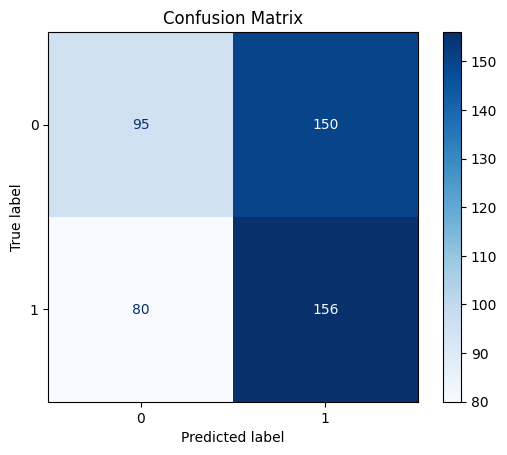

In [450]:
def print_cm(y_test, y_pred, title=None):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    plt.show()
    return
print_cm(y_test, y_pred)

Проверим насколько хорошо работает модель в разрезе сигналов технических индикаторов.

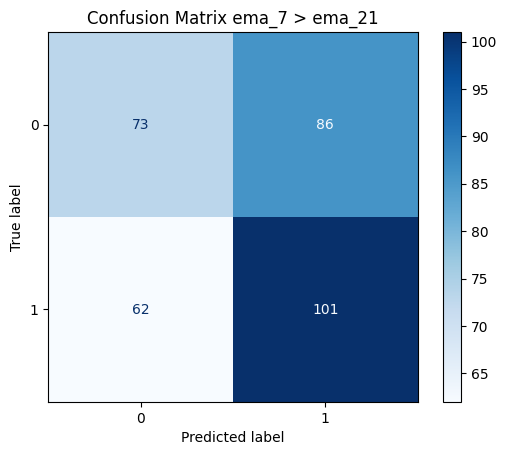

Accuracy (EMA Crossover): 0.5403726708074534


In [469]:
# Если 'ema_7'  > 'ema_21'
y_pred_series = pd.Series(y_pred, index=X_test.index)

mask_ema = (X_test['ema_7']  > X_test['ema_21'])

X_ema = X_test[mask_ema]
y_true  = y_test[mask_ema]
y_pred_ema = y_pred_series[mask_ema]

print_cm(y_true, y_pred_ema,title='Confusion Matrix ema_7 > ema_21')
print("Accuracy (EMA Crossover):", accuracy_score(y_true, y_pred_ema))

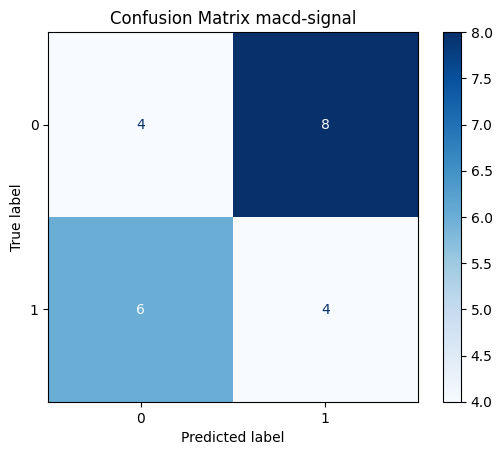

0.36363636363636365


In [452]:
# Сигнал покупки продажи по 'macd'
mask = (
    (X_test['macd'].shift(1) < X_test['macd_signal'].shift(1)) &
    (X_test['macd'] > X_test['macd_signal']) |
    (X_test['macd'].shift(1) > X_test['macd_signal'].shift(1)) &
    (X_test['macd'] < X_test['macd_signal'])
  )

X_test[mask]
y_true = y_test[mask]
y_pred_masked = y_pred_series[mask]

print_cm(y_true, y_pred_masked, title='Confusion Matrix macd-signal')

print(accuracy_score(y_true, y_pred_masked))

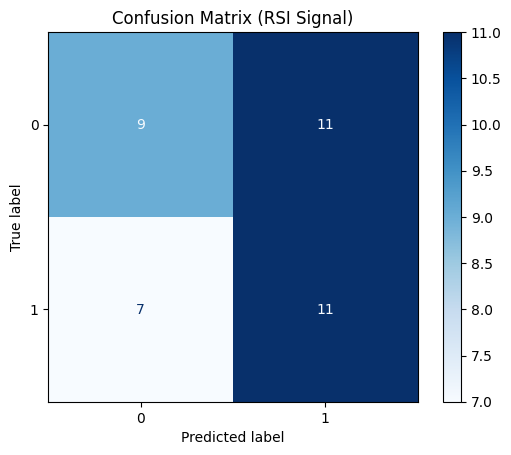

Accuracy: 0.5263157894736842


In [456]:
# сигнал rsi_7
mask = (
    ((X_test['rsi_7'].shift(1) < 30) & (X_test['rsi_7'] >= 30) |  # Вход из перепроданности
    (X_test['rsi_7'].shift(1) > 70) & (X_test['rsi_7'] <= 70))    # Выход из перекупленности
)

X_rsi = X_test[mask]
y_true = y_test[mask]
y_pred_masked = y_pred_series[mask]

print_cm(y_true, y_pred_masked, title="Confusion Matrix (RSI Signal)")
print("Accuracy:", accuracy_score(y_true, y_pred_masked))

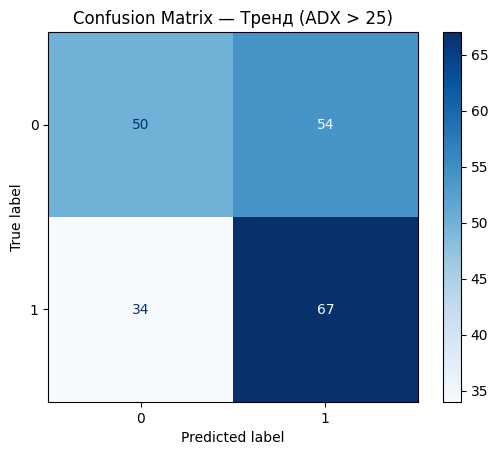

Accuracy (тренд): 0.5707317073170731


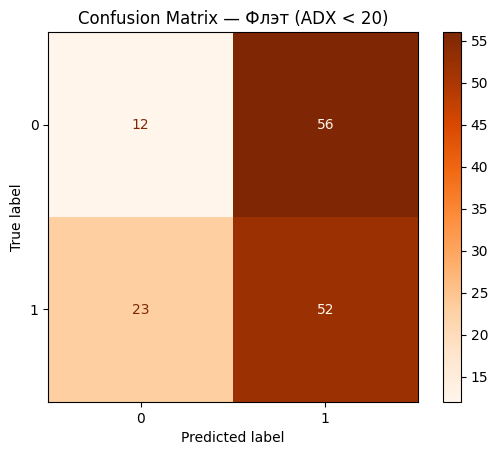

Accuracy (флэт): 0.44755244755244755


In [457]:
# Порог силы тренда
trend_threshold = 25
flat_threshold = 20

mask_trend = X_test['adx_21'] > trend_threshold
mask_flat = X_test['adx_21'] < flat_threshold

y_true_trend = y_test[mask_trend]
y_pred_trend = y_pred_series[mask_trend]

print_cm(y_true_trend, y_pred_trend,title="Confusion Matrix — Тренд (ADX > 25)")
print("Accuracy (тренд):", accuracy_score(y_true_trend, y_pred_trend))


# === Флэт ===
y_true_flat = y_test[mask_flat]
y_pred_flat = y_pred_series[mask_flat]

cm_flat = confusion_matrix(y_true_flat, y_pred_flat)
disp_flat = ConfusionMatrixDisplay(confusion_matrix=cm_flat)
disp_flat.plot(cmap='Oranges')
plt.title("Confusion Matrix — Флэт (ADX < 20)")
plt.show()
print("Accuracy (флэт):", accuracy_score(y_true_flat, y_pred_flat))

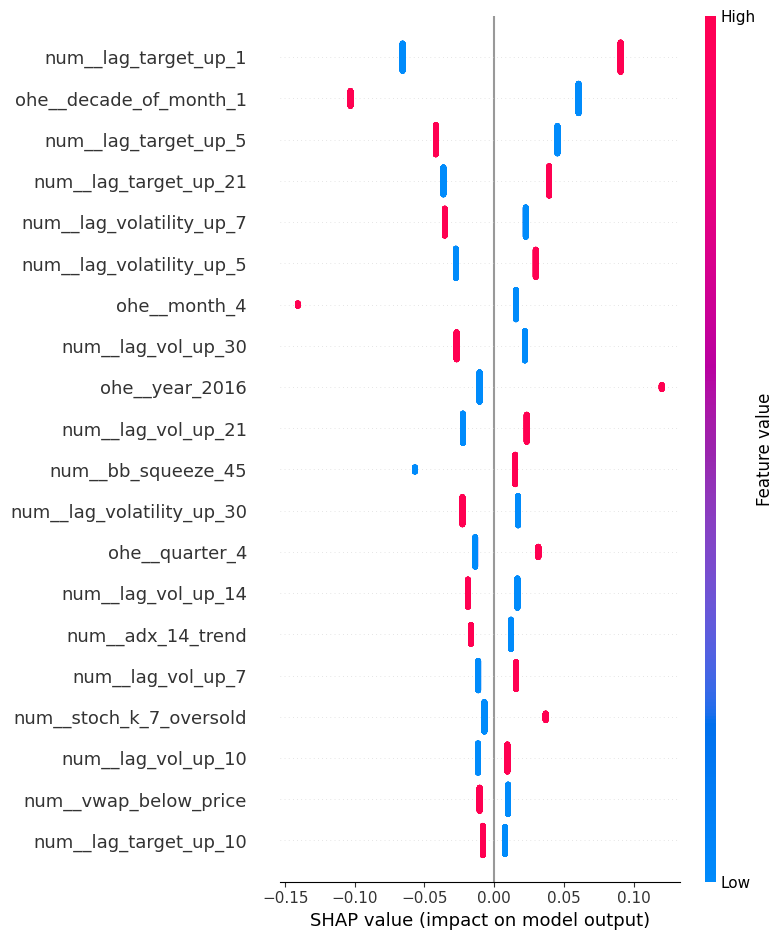

In [458]:
import shap
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']

pre_and_select = Pipeline([
    ('preprocessor', best_pipeline.named_steps['preprocessor']),
    ('select',       best_pipeline.named_steps.get('select'))
]).set_params(select__k = best_pipeline.named_steps['select'].k) # если у селектора есть параметры

X_train_transformed_10 = pre_and_select.transform(X_train)

explainer = shap.LinearExplainer(best_model, X_train_transformed_10)
shap_values = explainer.shap_values(X_train_transformed_10)
shap.summary_plot(shap_values, features=X_train_transformed_10, feature_names=pre_and_select.get_feature_names_out())

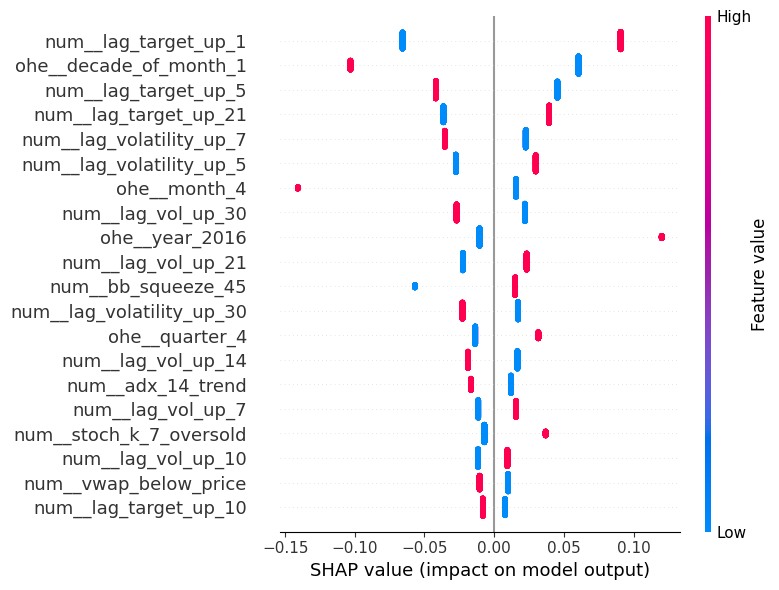

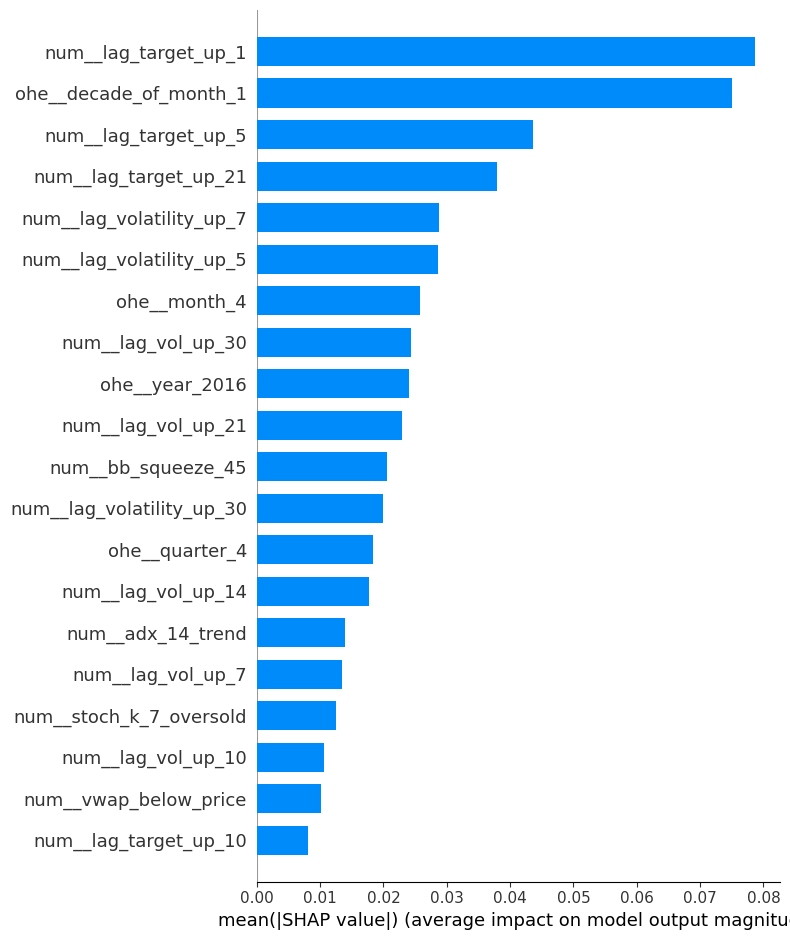

<Figure size 640x480 with 0 Axes>

In [459]:
best_pipeline = randomized_search.best_estimator_
best_model    = best_pipeline.named_steps['models']

pre_and_select = Pipeline([
    ('preprocessor', best_pipeline.named_steps['preprocessor']),
    ('select',       best_pipeline.named_steps.get('select'))
])

if 'select' in best_pipeline.named_steps:
    pre_and_select.set_params(select__k = best_pipeline.named_steps['select'].k)

X_train_transformed_10 = pre_and_select.transform(X_train)

explainer = shap.LinearExplainer(best_model, X_train_transformed_10)

shap_values = explainer.shap_values(X_train_transformed_10)


feature_names_final = pre_and_select.get_feature_names_out()

shap.summary_plot(
    shap_values,
    features=X_train_transformed_10,
    feature_names=feature_names_final,
    plot_size=(8, 6)
)

plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    features=X_train_transformed_10,
    feature_names=feature_names_final,
    plot_type="bar",
    max_display=20
)

plt.tight_layout()
plt.show()


#### Выводы по разделу Обучение модели (классические модели):
- Лучшая модель логистическая регрессия с метрикой accuracy равна 0.52.
- В разрезе сигналов техиндикаторов модель также показывает метрику accuracy в диапазоне 0.50-0,57.
- Исследована важность признаков (SHAP - анализ) лучшей модели: признаки связанные таргетом объемом технические индикаторы

### Обучение модели на полносвязной нейросети

На классический моделях не получилось получить нормальную метрику, принято решение попробовать обучить на полносвязной нейросети

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 - 3s - 60ms/step - accuracy: 0.5042 - loss: 0.9571 - val_accuracy: 0.5195 - val_loss: 0.7977
Epoch 2/200
49/49 - 0s - 7ms/step - accuracy: 0.5042 - loss: 0.9802 - val_accuracy: 0.5039 - val_loss: 0.8336
Epoch 3/200
49/49 - 0s - 5ms/step - accuracy: 0.5257 - loss: 0.9411 - val_accuracy: 0.5013 - val_loss: 0.8614
Epoch 4/200
49/49 - 0s - 5ms/step - accuracy: 0.5166 - loss: 0.9581 - val_accuracy: 0.5065 - val_loss: 0.8824
Epoch 5/200
49/49 - 0s - 5ms/step - accuracy: 0.5016 - loss: 0.9472 - val_accuracy: 0.5091 - val_loss: 0.8971
Epoch 6/200
49/49 - 0s - 6ms/step - accuracy: 0.5289 - loss: 0.9535 - val_accuracy: 0.5091 - val_loss: 0.9079
Epoch 7/200
49/49 - 0s - 5ms/step - accuracy: 0.5068 - loss: 0.9601 - val_accuracy: 0.5169 - val_loss: 0.9163
Epoch 8/200
49/49 - 0s - 5ms/step - accuracy: 0.5153 - loss: 0.9498 - val_accuracy: 0.5169 - val_loss: 0.9216
Epoch 9/200
49/49 - 0s - 6ms/step - accuracy: 0.5153 - loss: 0.9484 - val_accuracy: 0.5143 - val_loss: 0.9222
Epoch 10/200
49/49 - 

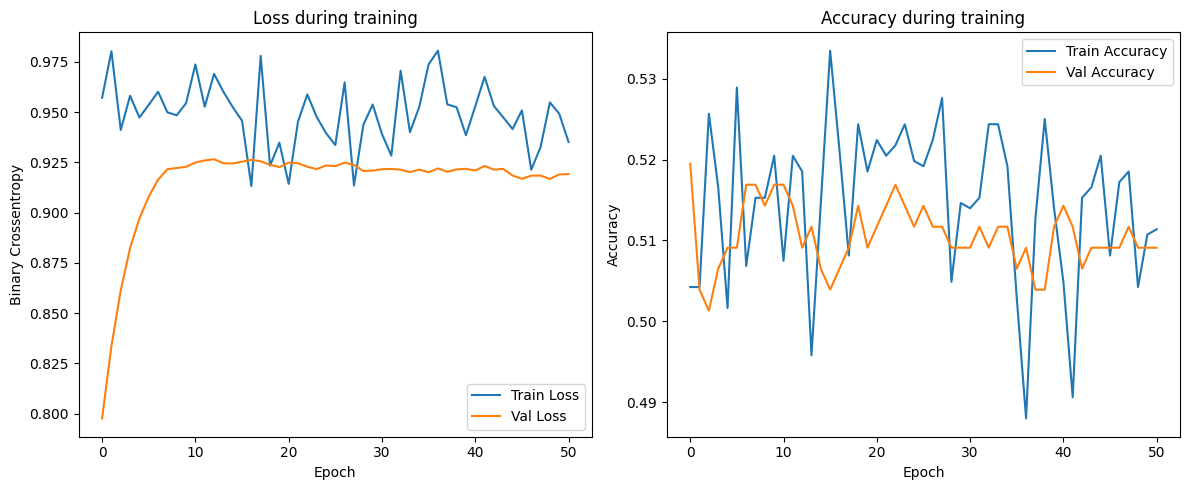

In [468]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)


model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32,kernel_regularizer=regularizers.l2(1e-4), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-6),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stop]
)


loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}   |   Test Accuracy: {acc:.4f}")


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],  label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


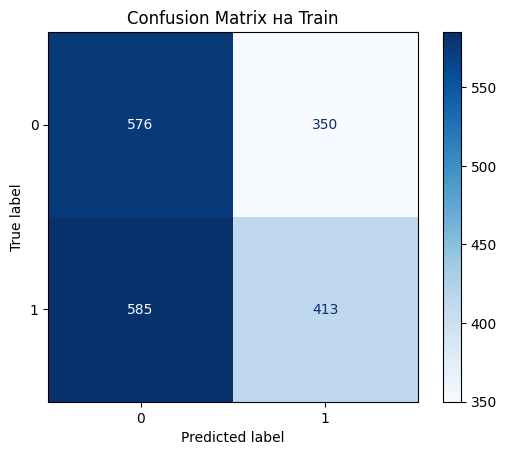

Accuracy на Train: 0.514033264033264


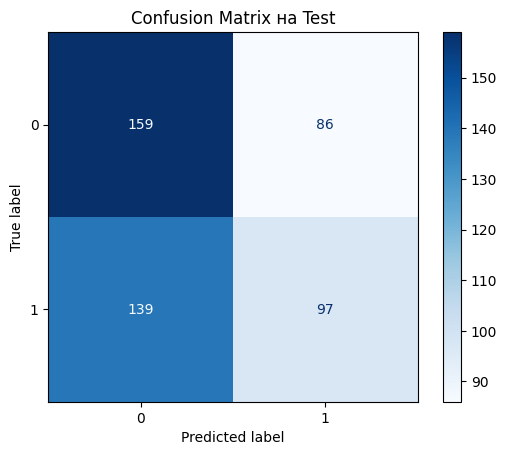

Accuracy на Test: 0.5322245322245323


In [473]:
y_train_prob = model.predict(X_train_scaled)
y_test_prob  = model.predict(X_test_scaled)

y_train_pred = (y_train_prob.flatten() >= 0.5).astype(int)
y_test_pred  = (y_test_prob.flatten()  >= 0.5).astype(int)

print_cm(y_train, y_train_pred,title="Confusion Matrix на Train")
print("Accuracy на Train:",accuracy_score(y_train, y_train_pred))
print_cm(y_test, y_test_pred, title="Confusion Matrix на Test")
print("Accuracy на Test:",accuracy_score(y_test, y_test_pred))

Выводы по разделу Обучение модели (нейронные сети):
- В качестве «базовой» было решено взять MLP с архитектурой (128 → 64 → 32 → 1).

### Выводы по проекту
Обучены классические модели и полносвязная нейросеть. Метрика оказались оказалась в диапазоне 0,53-0,57 на тесте.

Что можно улучшить в модлях:
- сгенерировать фичи по подтянутым данным: индекс Голубые фишки, индекс Нефти и газа и Brent.
- подтянуть отчетность компании Лукойл.
- цены акций часто реагируют на новости, макроэкономические индикаторы, кредитные спреды, валютные курсы. В данном проекте были использованы только исторические котировки и «чистая» техническая аналитика — добавление внешних данных может повысить качество,
- расширить window при расчёте сезонности: обнаруженная периодичность (~45 дней). Можно экспериментировать с другими period при разложении (скажем, 21 или 60) и смотреть, какие циклы улучшают прогноз.
- попробовать другие  архитектуры LSTM/GRU/RNN.
